# Hidden Shift Problem

In this notebook, we introduce the hidden shift problem and two different quantum algorithms to solve it. We then implement these algorithms using Qiskit and run on a simulator and device.

## Contents

1. [The Hidden Shift Problem](#hidden-shift-problem)  
   1.1 [The Boolean Hidden Shift Problem](#boolean-hidden-shift-problem)  
   1.2 [The Classical Solution](#classical-solution)  
   1.3 [The Quantum Solution](#quantum-solution)  
2. [Example](#example)  
3. [Qiskit Implementation: Fourier-Transform-Accessible Algorithm](#ftaa)  
   3.1 [Simulation](#ftaa-simulation)  
   3.2 [Device](#ftaa-device)  
4. [Qiskit Implementation: Fourier-Transform-Free Algorithm](#ftfa)  
   4.1 [Simulation](#ftfa-simulation)  
   4.2 [Device](#ftfa-device)  
<!-- 5. [Qiskit Implementation: Integer Hidden Shift Problem](#ihsp)  
   5.1 [Simulation](#ihsp-simulation)  
   5.2 [Device](#ihsp-device)   -->
5. [Problems](#problems)  
<!-- 7. [Breaking Poly1305 Encryption](#poly1305)   -->
6. [References](#references)

### 1. The Hidden Shift Problem <a id='hidden-shift-problem'> </a>

The hidden shift problem is an oracle-based problem which is closely related to Simon's problem and factorization problem. There exists an quantum algorithm that solves the hidden shift problem on a boolean function with $O(n)$ queries, having exponential speedup compared to the classical algorithm.

While it is unknown if the problem on an integer-valued function is also efficiently solvable via quantum computers, it is a major research area till today, as quantum advantages continue to be found in similar problems.

We can model some generally used cryptographies like Poly1305 and CSIDH as the hidden shift problem, and it is also employed to benchmark quantum computers and simulators.

In this notebook, we will focus on the hidden shift problem on a boolean fucntion.

### 1.1 The Boolean Hidden Shift Problem <a id='boolean-hidden-shift-problem'> </a>

Suppose $n$-bit boolean functions $f, g: \mathbb{Z}^n_2 \rightarrow \mathbb{Z}_2$ satisfies the following properties:

- **non-periodic**: if $f(x + t) = f(x)$ for some $t$, then $t=0$
- **shift relation**: there exists $s \in \mathbb{Z}^n_2$ such that $f(x + s) = g(x)$

Given an oracle that encodes $f$ and $g$, how can we find the hidden shift $s$ while accessing the oracle as little as possible?

### 1.2 The Classical Solution <a id='classical-solution'> </a>

It has been proved that the classical query complexity of the boolean hidden shift problem is in $\Omega(2^{n/2})$. In general, we can simply employ the brute-force approach putting in all possible inputs to classify $f(x)$ and $g(x)$. It costs $2 \cdot 2^n$ oracle queries.

### 1.3 The Quantum Solution <a id='quantum-solution'> </a>

Before we learn about this algorithm, we must first talk about the Fourier transform on the boolean group $\mathbb{Z}^n_2$. Here we mean by "boolean group" where the addition is defined by bitwise modular addition, so that $01 + 11 = 10$ for example. For any real valued function $f : \mathbb{Z}^n_2 \rightarrow \mathbb{R}$, the Fourier transform of $f$ is a function $\tilde{f} : \mathbb{Z}^n_2 \rightarrow \mathbb{R}$ defined by:

$$
\tilde{f}(x) = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{x \cdot y}f(y)
$$

It is quite interesting that this specific Fourier transform is called "Hadamard transform", while the Hadamard transform on qubits is defined by:

$$
H \left| x \right> = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{x \cdot y} \left| y \right>,
$$

#### 1.3a Fourier-transform-accessible algorithm

If the given oracle lets you access to the Fourier-transformed function $\tilde{f}$, there exists an one-shot algorithm that directly returns $\left| s \right>$

![hsp_ftaa](images/hsp_ftaa.jpg)

The oracles $U_{g}$ and $U_{\tilde{f}}$ flip phases of input state $\left| x \right>$ according to each function $g$ and $\tilde{f}$, so $U_{g} \left| x \right> = (-1)^{g(x)} \left| x \right>$ and $U_{\tilde{f}} \left| x \right> = (-1)^{\tilde{f}(x)} \left| x \right>$. We can simply denote $(-1)^{f(x)} = F(x)$, then we can also benefit from the fact that $\tilde{F}(x) = (-1)^{\tilde{f}(x)}$.

Now, let's go through the steps of the algorithm:

<ol>
   <li>
        The $n$-qubit register is initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 0 \right> ^{\otimes n}
$$

   </li>
   
   <li>
        Apply a Hadamard transform to the whole register:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| x \right>
$$

   </li>

   <li>
        Query the oracle $U_{g}$:  
$$
\begin{aligned}
    \left| \psi_3 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} G(x) \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x + s) \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard gates again to the register:  
$$
\begin{aligned}
    \left| \psi_4 \right>
        & = \frac{1}{2^n} \sum_{y} \left[ \sum_{x} (-1)^{x \cdot y} F(x + s) \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left[ \frac{1}{\sqrt{2^n}} \sum_{x} (-1)^{(x + s) \cdot y} F(x + s) \right] \left| y \right>
\end{aligned}
$$

We can rewrite $(x + s)$ as $x$, because the index runs for every possible inputs, so we get:  
$$
= \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left[ \frac{1}{\sqrt{2^n}} \sum_{x} (-1)^{x \cdot y} F(x) \right] \left| y \right>
$$

However the term inside square brackets is nothing but the $\tilde{F}$:  
$$
= \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \tilde{F}(y) \left| y \right>
$$

   </li>

   <li>
        Query the oracle $U_{\tilde{f}}$:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \tilde{F}(y) \tilde{F}(y) \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} (-1)^{s \cdot y} \left| y \right>
\end{aligned}
$$
        
   </li>

   <li>
        Finally, retrieve $\left| s \right>$ by cancelling out the Hadamard transform:  
$$
\left| \psi_6 \right> = \left| s \right>
$$
        
   </li>
</ol>

#### 1.3b Fourier-transform-free algorithm

When we do not have access to the Fourier-transformed function $\tilde{f}$, we can still solve the problem with $O(n)$ query complexity, which actually has exponential speedup.

![hsp_ftfa](images/hsp_ftfa.jpg)

<ol>
   <li>
        The output register and $n$-qubit input register are initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 0 \right> \left| 0 \right>^{\otimes n}
$$
   </li>
   
   <li>
        Apply Hadamard gates on the input register to create uniform superposition:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| 0 \right> \left| x \right>
$$

   </li>

   <li>
        Query the oracle $O_f$:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| f(x) \right> \left| x \right>
$$

   </li>

   <li>
        Apply Z gate on the output register:  
$$
\begin{aligned}
    \left| \psi_4 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} (-1)^{f(x)} \left| f(x) \right> \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) \right> \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Query the oracle $O_g$:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) + g(x) \right> \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard transform on the input register:  
$$
\begin{aligned}
    \left| \psi_6 \right>
        & = \frac{1}{2^n} \sum_{x, y} (-1)^{x \cdot y} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{2^n} \sum_{x, y} \left[ \frac{(-1)^{x \cdot y} F(x) + (-1)^{x \cdot y} F(x + s)}{2} \left| 0 \right> + \frac{(-1)^{x \cdot y} F(x) - (-1)^{x \cdot y} F(x + s)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} \left[ \frac{\tilde{F}(y) + (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 0 \right> + \frac{\tilde{F}(y) - (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 1 \right> \right] \left| y \right>
\end{aligned}
$$

Then we can simplify the equation with the binary index $b$:  
$$
\begin{aligned}
    & = \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \left| b \right> \left| y \right>
\end{aligned}
$$

Now we measure the state $\left| b, y \right>$, then the probability of getting a result $\left| b_0, y_0 \right>$ is:  
$$
\begin{aligned}
    P(b_0, y_0)
        & = \left| \left< b_0, y_0 \middle| \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \middle| b, y \right> \right| ^2 \\
        & = \frac{1}{2^n} \cdot \left| \tilde{F}(y_0) \right| ^2 \cdot \left| \frac{1 + (-1)^{(1, s) \cdot (b_0, y_0)}}{2} \right| ^2 \\
        & = \frac{\delta ((1, s) \cdot (b_0, y_0))}{2^n}
\end{aligned}
$$

It clearly states that the result is an uniform superposition of the states that are orthogonal to the state $\left| 1, s \right>$.

Once you get the outputs $(b_1, y_1), (b_2, y_2), \cdots (b_n, y_n)$, we can solve the following equation to find $\left| s \right>$:

$$
\begin{cases}
    s \cdot y_1 = b_1 \\
    s \cdot y_2 = b_2 \\
    \vdots \\
    s \cdot y_n = b_n
\end{cases}
$$

The hidden shift $s$ can be uniquely characterized by $n$ independent $y_i$s, so we repeat the algorithm a total number of $O(n)$ times to get a constant probability to get a sufficient number of bitstrings.

   </li>
</ol>

## 2. Example <a id='example'> </a>

Let's go through a specific example of the hidden shift algorithm for the case $n=2$ and $s=10$. As the oracle must be able to encode the Fourier-transformed function $\tilde{f}$, we employ the Maiorana-McFarland class of bent functions: $\mathbb{Z}^n_2 \rightarrow \mathbb{Z}_2$ mapping the input string $(x, y) \rightarrow f(x, y)$ as below.

$$
f(x, y) = x \cdot y + h(x) \quad \mathrm{where \;} h(x) \mathrm{\; is \; an \; arbitrary \; boolean \; function \;} \mathbb{Z}^{n/2}_2 \rightarrow \mathbb{Z}_2
$$

For this special class of boolean function, it is known that

$$
\tilde{f}(x, y) = x \cdot y + h(y)
$$

In this example, we simply choose $h(x) = x$ to get the output table as below.

| $$(x,y)$$ | $$f(x,y)$$ | $$g(x,y)$$ | $$\tilde{f}(x,y)$$ |
|:--:|:-:|:-:|:-:|
| 00 | 0 | 0 | 0 |
| 01 | 1 | 0 | 0 |
| 10 | 0 | 0 | 1 |
| 11 | 0 | 1 | 0 |

Now for this set of conditions, each algorithm works as follows:

### 2.1 Fourier-Transform-Accessible Algorithm

<ol>
   <li>
        The 2-qubit register is initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 00 \right>
$$

   </li>
   
   <li>
        Apply a Hadamard transform to the whole register:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^2}} \left[ \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \right]
$$

   </li>

   <li>
        Query the oracle $U_{g}$:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^2}} \left[ \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \right]
$$

   </li>

   <li>
        Apply Hadamard gates again to the register:  
$$
\begin{aligned}
    \left| \psi_4 \right> = \frac{1}{2^2} ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
        + & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \\[6pt]
        + & \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \\[6pt]
        - & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; )
\end{aligned}
$$

Summing up vertically, we get:
$$
= \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Query the oracle $U_{\tilde{f}}$:  
$$
\left| \psi_5 \right> = \frac{1}{\sqrt{2^2}} \left( \; \left| 00 \right> + \left| 01 \right> - \left| 10 \right> - \left| 11 \right> \; \right)
$$

   </li>

   <li>
        Finally, retrieve $\left| s \right>$ by cancelling out the Hadamard transform:  
$$
\begin{aligned}
    \left| \psi_6 \right> = \frac{1}{2^2} ( \;
        & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[5pt]
        + & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \\[6pt]
        - & \left| 00 \right> - \left| 01 \right> + \left| 10 \right> + \left| 11 \right> \\[6pt]
        - & \left| 00 \right> + \left| 01 \right> + \left| 10 \right> - \left| 11 \right> \; ) \\[6pt]
    = \left| 10 \right> & = \left| s \right>
\end{aligned}
$$
        
   </li>
</ol>

### 2.2 Fourier-Transform-Free Algorithm

![hsp_ftfa2.2](images/hsp_ftfa2.2.jpg)

<ol>
   <li>
        The output register and $n$-qubit input register are initialized to the zero state:  
$$
\left| \psi_1 \right> = \left| 0 \right> \left| 0 \right>^{\otimes n}
$$
   </li>
   
   <li>
        Apply Hadamard gates on the input register to create uniform superposition:  
$$
\left| \psi_2 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| 0 \right> \left| x \right>
$$

   </li>

   <li>
        Query the oracle $O_f$:  
$$
\left| \psi_3 \right> = \frac{1}{\sqrt{2^n}} \sum_{x} \left| f(x) \right> \left| x \right>
$$

   </li>

   <li>
        Apply Z gate on the output register:  
$$
\begin{aligned}
    \left| \psi_4 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} (-1)^{f(x)} \left| f(x) \right> \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) \right> \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Query the oracle $O_g$:  
$$
\begin{aligned}
    \left| \psi_5 \right>
        & = \frac{1}{\sqrt{2^n}} \sum_{x} F(x) \left| f(x) + g(x) \right> \left| x \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{x} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| x \right>
\end{aligned}
$$

   </li>

   <li>
        Apply Hadamard transform on the input register:  
$$
\begin{aligned}
    \left| \psi_6 \right>
        & = \frac{1}{2^n} \sum_{x, y} (-1)^{x \cdot y} \left[ \frac{F(x) + G(x)}{2} \left| 0 \right> + \frac{F(x) - G(x)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{2^n} \sum_{x, y} \left[ \frac{(-1)^{x \cdot y} F(x) + (-1)^{x \cdot y} F(x + s)}{2} \left| 0 \right> + \frac{(-1)^{x \cdot y} F(x) - (-1)^{x \cdot y} F(x + s)}{2} \left| 1 \right> \right] \left| y \right> \\
        & = \frac{1}{\sqrt{2^n}} \sum_{y} \left[ \frac{\tilde{F}(y) + (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 0 \right> + \frac{\tilde{F}(y) - (-1)^{s \cdot y} \tilde{F}(y)}{2} \left| 1 \right> \right] \left| y \right>
\end{aligned}
$$

Then we can simplify the equation with the binary index $b$:  
$$
\begin{aligned}
    & = \frac{1}{\sqrt{2^n}} \sum_{b, y} \tilde{F}(y) \left( \frac{1 + (-1)^{(1, s) \cdot (b, y)}}{2} \right) \left| b \right> \left| y \right>
\end{aligned}
$$

   </li>
</ol>

## 3. Qiskit Implementation: Fourier-Transform-Accessible Algorithm <a id='ftaa'> </a>

Now we will walk through the algorithm for the case in which we have an access to the Fourier transformed function. We will implement it via Qiskit for a 4-bit string $s=1011$.

In [1]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

We first set the number of qubits $n$ and the hidden shift $s$.

In [2]:
n = 4         # number of input qubits
s = '1011'    # the binary hidden shift string

The hidden shift $s$ together with some boolean function $f$ determines the circuit for the quantum oracle. As we have to implement the Fourier transformed function $\tilde{f}$, we employ again the Maiorana-McFarland class of bent functions. Here we employ the AND function $h(x) = x_1 x_2$ for example. Then the boolean function $f$ is defined as follows:

$$
f(x, y) = x \cdot y + h(x) = (x_1 y_1 + x_2 y_2) + x_1 x_2
$$

From now on, we would see how we use Qiskit to encode the oracles $U_{g}$ and $U_{\tilde{f}}$ in our example. Remind that the oracles are running in some cryptosystem, so they are hidden and not revealed. We are aiming to check whether our algorithm could give the hidden shift $s$ for this specific example.

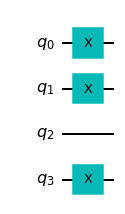

In [3]:
def shift_s(n, s):
    """Shifting operation for the given string s"""
    shift_s = QuantumCircuit(n)
    s = s[::-1]    # reverse s to fit qiskit's qubit ordering
    for i in range(n):
        if s[i] == '0': 
            continue
        else:
            shift_s.x(i)    # apply X-gates to shift the input
    shift_s.name = 'S(x)'
    return shift_s

# Display circuit
shift_s(n, s).draw('mpl')

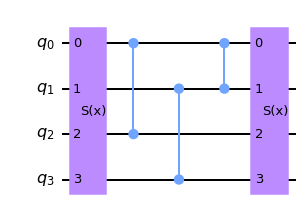

In [4]:
def oracle_g(n):
    """Oracle g"""
    oracle_g = QuantumCircuit(n)
    oracle_g.append(shift_s(n, s), qargs=range(n))    # shift the inputs
    
    # Apply F(x) = (-1)^f(x)
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_g.cz(i,i+int(n/2))
    
    # h(x) in our example corresponds to the controlled-z gate between first and second qubits
    oracle_g.cz(0, 1)
    
    oracle_g.append(shift_s(n, s), qargs=range(n))    # return the inputs
    oracle_g.name = 'Oracle g'
    return oracle_g

# Display circuit
oracle_g(n).draw('mpl')

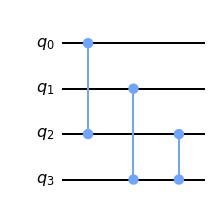

In [5]:
def oracle_f_tilde(n):
    """Oracle f tilde"""
    oracle_f_tilde = QuantumCircuit(n)
    
    # Apply the Fourier transformed function
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_f_tilde.cz(i,i+int(n/2))
    
    # Apply h(y), that is, a controlled-z gate on second half qubits
    oracle_f_tilde.cz(2, 3)
    
    oracle_f_tilde.name = 'Oracle f tilde'
    return oracle_f_tilde

# Display circuit
oracle_f_tilde(n).draw('mpl')

We have implemented the oracles so far. Now we implement the actual algorithm circuit to compute the hidden shift $s$ from the oracles.

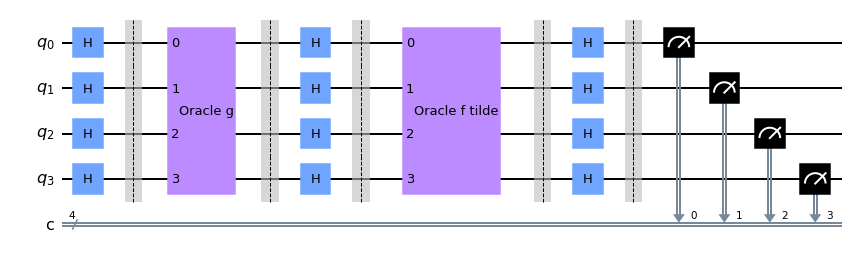

In [6]:
hsp_circuit = QuantumCircuit(n, n)

# Apply Hadamard gates to make superposition
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()    # barrier is for visual separation

# Query the oracle g by appending the oracle circuit on ours
hsp_circuit.append(oracle_g(n), range(n))
hsp_circuit.barrier()

# Apply Hadamard gates to perform a boolean Fourier transform
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Query the oracle f tilde
hsp_circuit.append(oracle_f_tilde(n), range(n))
hsp_circuit.barrier()

# Retrieve s by performing the boolean Fourier transform again
for i in range(n):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Measure all qubits
for i in range(n):
    hsp_circuit.measure(i, i)

# Display circuit
hsp_circuit.draw('mpl')

### 3.1 Experiment with Simulators <a id='ftaa-simulation'> </a>

We can run the above circuit on the simulator.

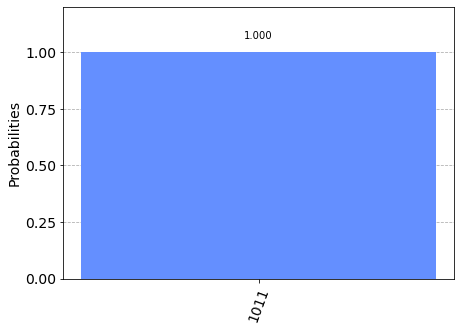

In [7]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

We can see that the result of the measurement is the hidden string 1011.

### 3.2 Experiment with Real Devices <a id='ftaa-device'> </a>

We can run the circuit on the real device as below.

In [8]:
# Load our saved IBMQ accounts and get the least busy backend device with more than or equal to n qubits
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x:
                                       int(x.configuration().n_qubits) <= 4*n
                                       and int(x.configuration().n_qubits) >= n
                                       and not x.configuration().simulator
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [9]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


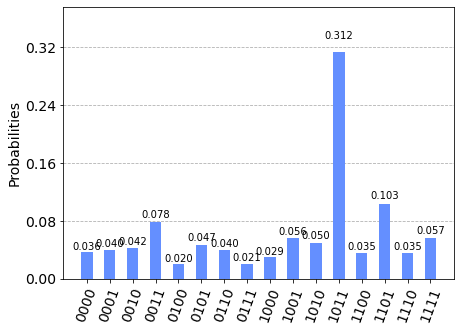

In [10]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

As we can see, there is a significatly higher chance of measuring $\left| 1011 \right>$. The other results are due to errors in the real device.

## 3. Qiskit Implementation: Fourier-Transform-Free Algorithm <a id='ftfa'> </a>

Now we go through the more general case where the oracle does not provide the Foruier-transformed function $\tilde{f}$. The second algorithm requires $2n+1$ qubits, but the current free-accessible number of qubits is up to 5. Thus we reduce the input size to 2 qubits, and then we can employ the function used in the example section again:

$$
f(x, y) = x \cdot y + x
$$

Now $n=2$ and $s=10$.

In [11]:
n = 2       # number of input qubits
s = '10'    # the binary hidden shift string

In [12]:
def oracle_f(n):
    """Oracle f"""
    oracle_f = QuantumCircuit(n)
    
    # Implement F(x) = (-1)^f(x)
    # x·y corresponds to controlled-z gates between first half qubits and second half qubits
    for i in range(int(n/2)):
        oracle_f.cz(i,i+int(n/2))
    
    # h(x) in this case is simply the z gate on the first qubit
    oracle_f.z(0)
    
    oracle_f.name = 'Oracle f'
    return oracle_f.to_gate()

def oracle_g(n, s):
    """Oracle g"""
    oracle_g = QuantumCircuit(n)
    oracle_g.compose(shift_s(n, s), inplace=True)    # shift the inputs
    oracle_g.append(oracle_f(n), range(n))           # apply the oracle f
    oracle_g.compose(shift_s(n, s), inplace=True)    # return the inputs
    oracle_g.name = 'Oracle g'
    return oracle_g.to_gate()

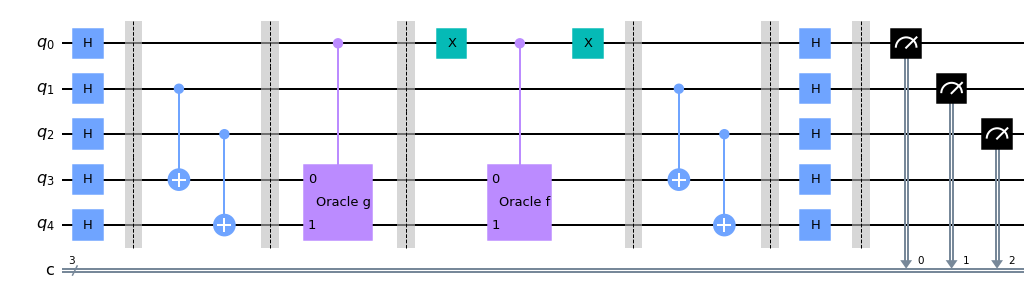

In [13]:
# Implement the Fourier-transform-free algorithm
hsp_circuit = QuantumCircuit(2*n+1, n+1)

# Apply Hadamard gates to make superposition
for i in range(2*n+1):
    hsp_circuit.h(i)
hsp_circuit.barrier()    # barrier is for visual separation

# Apply controlled-x gates from the second register to the third register
for i in range(n):
    hsp_circuit.cx(i+1, i+n+1)
hsp_circuit.barrier()

# Apply the oracle g according to the control qubit
hsp_circuit.append(oracle_g(n, s).control(), 
             [0] + [n+i+1 for i in range(n)])
hsp_circuit.barrier()

# Wrap up the control qubit with x gates to perform uncontrolled-oracle f
hsp_circuit.x(0)
hsp_circuit.append(oracle_f(n).control(), 
             [0] + [n+i+1 for i in range(n)])
hsp_circuit.x(0)
hsp_circuit.barrier()

# Apply controlled-x gates again
for i in range(n):
    hsp_circuit.cx(i+1, i+n+1)
hsp_circuit.barrier()

# Apply Hadamard gates to perform a boolean Fourier transform
for i in range(2*n+1):
    hsp_circuit.h(i)
hsp_circuit.barrier()

# Measure all qubits
for i in range(n+1):
    hsp_circuit.measure(i, i)

# Display circuit
hsp_circuit.draw('mpl')

### 4.1 Experiment with Simulators <a id='ftfa-simulation'> </a>

We can run the above circuit on the simulator. 

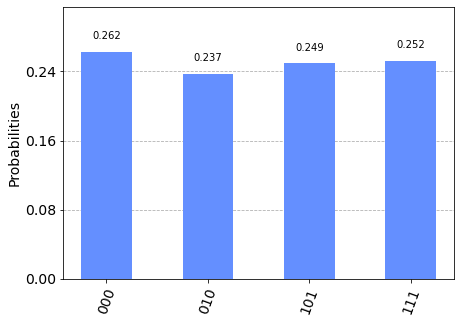

In [14]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

Now we see that there are 4 different results. Checking an inner product $\left<s, 1 \mid a \right>$, the outcome lists as below:

| $$(s,1)$$ | $$a$$ | $$\left<s, 1 \mid a \right>$$ |
|:---:|:---:|:-----:|
| 101 | 000 |   0   |
| 101 | 010 |   0   |
| 101 | 101 | 1+1=0 |
| 101 | 111 | 1+1=0 |

Note that we can retrieve $s$ as soon as we get two different outcomes except for all zeros. For example, when we get two linearly independent states $\left| 010 \right>$ and $\left| 101 \right>$, we can compute $s$ from them:

$$
\begin{cases}
    \left<s \mid 01 \right> = s_2 = 0 \\
    \left<s \mid 10 \right> = s_1 = 1
\end{cases}
\quad \therefore \left| s \right> = \left| s_1 s_2 \right> = \left| 10 \right>
$$

### 3.2 Experiment with Real Devices <a id='ftfa-device'> </a>

We can run the circuit on the real device as below.

In [15]:
# Load our saved IBMQ accounts and get the least busy backend device with more than or equal to 2*n+1 qubits
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x:
                                       int(x.configuration().n_qubits) <= 4*(2*n+1)
                                       and int(x.configuration().n_qubits) >= 2*n+1
                                       and not x.configuration().simulator
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [16]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_hsp_circuit = transpile(hsp_circuit, backend)
job = backend.run(transpiled_hsp_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


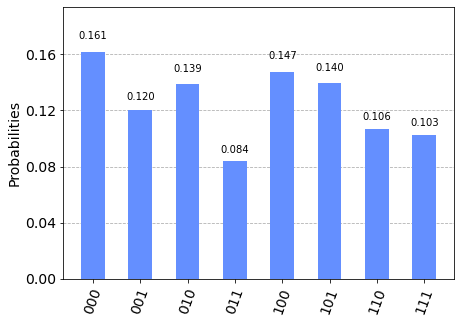

In [17]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In this case, however, we find that desired outputs are not distinguishable from the noise. The error correction or the error mitigation is the major area of study for quantum researchers who are aiming to tackle this kind of issues.

## 4. Problems <a id='problems'> </a>

The function `hsp_oracle` below takes an integer `seed`, and booleans `shifted` and `fourier_transformed`. It will return the boolean fucntion oracle with the input size 6. Use the hidden shift algorithm for the boolean bent function to find out the hidden shift $s$.

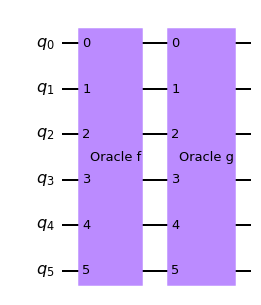

In [18]:
from problems import hsp_oracle
# Example usage
n = 6
seed = 137
oracle_f = hsp_oracle(seed, shifted=False, fourier_transformed=False)
oracle_g = hsp_oracle(seed, shifted=True, fourier_transformed=False)
qc = QuantumCircuit(n)
qc.append(oracle_f, range(n))
qc.append(oracle_g, range(n))
qc.draw('mpl')

1. Solve the hidden shift problem for the boolean bent function using the super oracle $O_\tilde{f}$.

In [ ]:
hsp_circuit = QuantumCircuit(n)

####################
# Your codes Here

####################

# Display circuit
hsp_circuit.draw('mpl')

In [ ]:
# Check the result
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

2. Solve the hidden shift problem for the boolean bent function not using the $O_\tilde{f}$

In [ ]:
hsp_circuit = QuantumCircuit(2*n+1)

####################
# Your codes Here

####################

# Display circuit
hsp_circuit.draw('mpl')

In [ ]:
# Check the result
aer_sim = Aer.get_backend('aer_simulator')
transpiled_hsp_circuit = transpile(hsp_circuit, aer_sim)
qobj = assemble(transpiled_hsp_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

## 5. References <a id='references'> </a>

1. M. Roetteler (2008), "Quantum algorithms for highly non-linear Boolean functions", Proceedings of the 21st Annual ACM-SIAM Symposium on Discrete Algorithms (SODA'10), pp. 448-457, [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) [quant-ph]
2. G. Kuperberg (2005), "A subexponential-time quantum algorithm for the dihedral hidden subgroup problem", SIAM Journal on Computing, 35(1), pp. 170-188, [doi:10.1137/S0097539703436345](https://doi.org/10.1137/S0097539703436345), [arXiv:quant-ph/0302112](https://arxiv.org/abs/quant-ph/0302112)
3. X. Bonnetain & M. Naya-Plasencia (2018), "Hidden Shift Quantum Cryptanalysis and Implications", In: T. Peyrin , S. Galbraith (eds) Advances in Cryptology – ASIACRYPT 2018, Lecture Notes in Computer Science, vol 11272, Springer, Cham, [doi:10.1007/978-3-030-03326-2_19](https://doi.org/10.1007/978-3-030-03326-2_19)
4. K. Wright, K. M. Beck, S. Debnath et al. (2019), "Benchmarking an 11-qubit quantum computer", Nat Commun 10, 5464, [doi:10.1038/s41467-019-13534-2](https://doi.org/10.1038/s41467-019-13534-2)
5. S. Bravyi & D. Gosset (2016), "Improved classical simulation of quantum circuits dominated by Clifford gates", Phys. Rev. Lett. 116, 250501, [doi:10.1103/PhysRevLett.116.250501](https://doi.org/10.1103/PhysRevLett.116.250501), [arXiv:1601.07601](https://arxiv.org/abs/1601.07601) [quant-ph]